In [160]:
import pandas as pd

from alphax.dataset import DATASET_DIR

train_data = pd.read_csv(f"{DATASET_DIR}/candle/5m/DOGE_USDT:USDT_2024-01-01 00:00:00_2024-07-01 00:00:00.csv")

# 打印train_data 的行数
train_data.count()

timestamp    52500
open         52500
high         52500
low          52500
close        52500
volume       52500
dtype: int64

<Axes: >

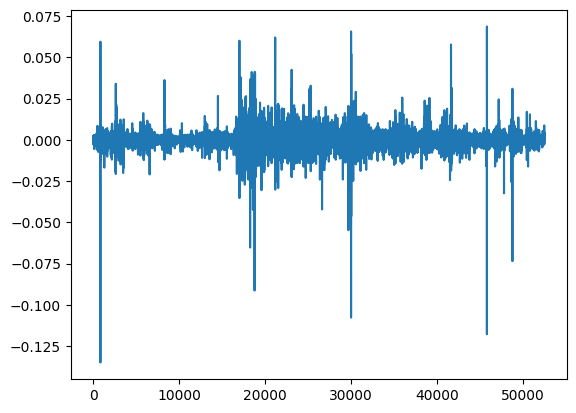

In [161]:
# 构建涨幅率，涨幅率 = (前一行的close - 后一行close) / 前一行的close
train_data['price_diff'] =  (train_data["close"].shift(-1) - train_data["close"])
train_data["change"] = train_data['price_diff']/ train_data["close"]

# 把涨幅率用图表展示出来
train_data["change"].plot()


In [162]:
# 把change大于0.01为true,小于0.01为false,赋值于 good_change
train_data["normal_change"] = train_data["change"] > 0
train_data["good_change"] = train_data["change"] > 0.01
# 统计一下good_change为true的数量
train_data["good_change"].value_counts()
# 把数据根据good_change 的值进行平衡数量



good_change
False    51964
True       536
Name: count, dtype: int64

In [163]:
# 删除open,high,low
train_data.drop(columns=["open", "high", "low"], inplace=True)
train_data

,timestamp,close,volume,price_diff,change,normal_change,good_change
0,2023-12-31 16:00:00,0.09018,3583000.0,0.00005,0.000554,True,False
1,2023-12-31 16:05:00,0.09023,1365000.0,0.00021,0.002327,True,False
2,2023-12-31 16:10:00,0.09044,3991000.0,-0.00001,-0.000111,False,False
3,2023-12-31 16:15:00,0.09043,4330000.0,0.00003,0.000332,True,False
4,2023-12-31 16:20:00,0.09046,1812000.0,0.00003,0.000332,True,False
...,...,...,...,...,...,...,...
52495,2024-06-30 22:35:00,0.12554,12051600.0,-0.00035,-0.002788,False,False
52496,2024-06-30 22:40:00,0.12519,11823500.0,-0.00029,-0.002316,False,False
52497,2024-06-30 22:45:00,0.12490,5788800.0,0.00032,0.002562,True,False
52498,2024-06-30 22:50:00,0.12522,8312800.0,-0.00019,-0.001517,False,False


<Axes: >

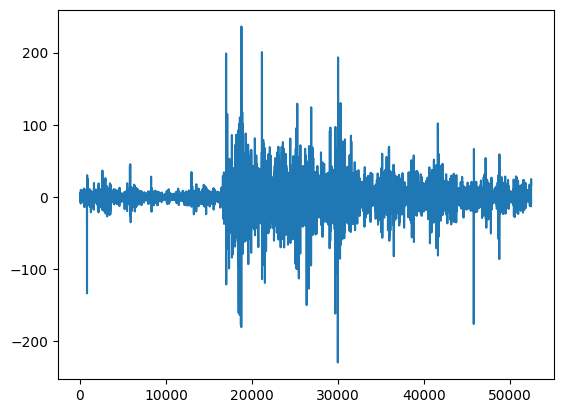

In [164]:
# 构建macd feature
from talib import MACD

macd, macd_signal, macd_hist = MACD(train_data['close'], fastperiod=12, slowperiod=26, signalperiod=9)
train_data['macd_hist'] = macd_hist * 100000
# 展示macd_hist，即使macd 的能量柱
train_data['macd_hist'].plot()


In [165]:
# 构建特征 macd_hist 是否连续X次上升
def macd_hist_up(macd_hist, n):
    macd_hist_up = macd_hist > 0
    for i in range(1, n):
        macd_hist_up = macd_hist_up and (macd_hist.shift(i) > 0)
    return macd_hist_up

# 构建特征 macd_hist 是否连续X次上升 并且 每次上升的差值也再上涨
def macd_hist_up_and_change_up(macd_hist, n):
    macd_hist_up = macd_hist > 0
    for i in range(1, n):
        macd_hist_up = macd_hist_up and (macd_hist.shift(i) > 0) and (macd_hist.shift(i) > macd_hist.shift(i+1))
    return macd_hist_up

train_data['macd连续上涨_3'] = macd_hist_up(train_data['macd_hist'], 3)
train_data['macd连续上涨_5'] = macd_hist_up(train_data['macd_hist'], 5)
train_data['macd连续放量上涨_3'] = macd_hist_up_and_change_up(train_data['macd_hist'], 3)
train_data['macd连续放量上涨_5'] = macd_hist_up_and_change_up(train_data['macd_hist'], 5)


train_data


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
# 查看两个列的关系
train_data[['macd连续放量上涨_3', 'normal_change']].value_counts()




In [ ]:
train_data[train_data['macd连续上涨_5'] == True]['good_change'].value_counts()